<a href="https://colab.research.google.com/github/xxshenanigans/AIB_Project4_DL/blob/main/project4_pt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **DATA SCIENCE / SECTION 4 / PROJECT**

---

> Text Image로부터 문자를 읽고, 그와 유사한 Image를 출력할 수 있을까 🤔

## 🤖 목차 

1. 개요
2. 모델 설계 및 학습 
3. 라벨 벡터화 및 코사인유사도 측정 
4. 결과 출력
5. 마무리 

---

#개요
문자인식(Character Recognition)이란 시각 정보를 통하여 문자를 인식하고 의미를 이해하는 인간의 능력을 컴퓨터로 실현하려는 패턴인식(Pattern Recognition)의 한 분야로서, 광학 문자 인식(Optical Character Recognition), 우편물 자동 분류, 문서인식, 도면인식 등의 분야에서 부분적으로 실용화가 이루어지게 되었으며, 요즈음에는 인공지능(Artificial Intelligence)의 최신기법인 신경망(Neural Network)과 접목에 의해 문자인식 기술은 새로운 단계에 접어들게 되었습니다.

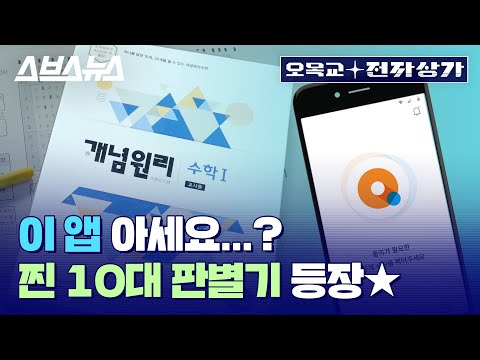

In [ ]:
from IPython.display import YouTubeVideo 
YouTubeVideo('3UREk0eMJH0', width=600, height=400)

###라이브러리 설치###

In [ ]:
from google.colab import drive
drive.mount('/content/drive') 

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import sys, cv2 
import random
import h5py
import os
import pytesseract
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

from numpy import dot 
from numpy.linalg import norm
from keras import backend as K
from keras.models import Model
from keras.layers import Input, Conv2D, Reshape, Bidirectional, LSTM, Dense, Lambda, BatchNormalization, MaxPooling2D, Activation, Dropout, Flatten
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
from PIL import Image
from google.colab.patches import cv2_imshow

#모델 설계 및 학습 

손글씨 문자를 인식하기 위해 CRNN(CNN+RNN) 모델을 학습합니다. 

### 데이터셋 불러오기

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/input/written_name_train_v2.csv')
valid = pd.read_csv('/content/drive/MyDrive/input/written_name_validation_v2.csv')

In [ ]:
train = train.head(33001)
valid = valid.head(4201)

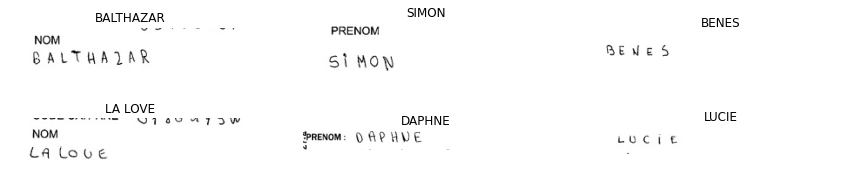

In [ ]:
plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '/content/drive/MyDrive/input/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(train.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

### 데이터 전처리
 - 라벨이 결측치인 이미지 제거 
 - 라벨이 'UNREADABLE'인 이미지 제거
 - 라벨 대문자로 통일

In [ ]:
train.dropna(axis=0, inplace=True)
valid.dropna(axis=0, inplace=True)

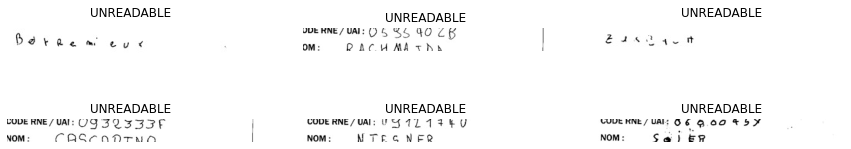

In [ ]:
unreadable = train[train['IDENTITY'] == 'UNREADABLE']
unreadable.reset_index(inplace = True, drop=True)

plt.figure(figsize=(15, 10))

for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '/content/drive/MyDrive/input/train/'+unreadable.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap = 'gray')
    plt.title(unreadable.loc[i, 'IDENTITY'], fontsize=12)
    plt.axis('off')

plt.subplots_adjust(wspace=0.2, hspace=-0.8)

In [ ]:
train = train[train['IDENTITY'] != 'UNREADABLE']
valid = valid[valid['IDENTITY'] != 'UNREADABLE']

In [ ]:
train['IDENTITY'] = train['IDENTITY'].str.upper()
valid['IDENTITY'] = valid['IDENTITY'].str.upper()

In [ ]:
train.reset_index(inplace = True, drop=True) 
valid.reset_index(inplace = True, drop=True)

In [ ]:
print(train.shape)
train.head(2)

(32934, 2)


,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON


In [ ]:
print(valid.shape)
valid.head(2)

(4189, 2)


,FILENAME,IDENTITY
0,VALIDATION_0001.jpg,BILEL
1,VALIDATION_0002.jpg,LAUMIONIER


- grayscale 적용 
- 크기는 가로 256, 세로 64로 통일 <br/>
 크기가 기준보다 크면 crop, 작으면 white pixel로 pad
- 0~1 범위로 정규화 

In [ ]:
def preprocess(img):
    (h, w) = img.shape
    
    final_img = np.ones([64, 256])*255   # blank white image
    
    # crop
    if w > 256:
        img = img[:, :256]
        
    if h > 64:
        img = img[:64, :]
    
    final_img[:h, :w] = img
    
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

In [ ]:
train_size = 16000
valid_size= 4000

In [ ]:
train_x = []

for i in range(train_size):
    img_dir = '/content/drive/MyDrive/input/train/'+train.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    train_x.append(image)

In [ ]:
valid_x = []

for i in range(valid_size):
    img_dir = '/content/drive/MyDrive/input/validation/'+valid.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    valid_x.append(image)

In [ ]:
train_x = np.array(train_x).reshape(-1, 256, 64, 1)
valid_x = np.array(valid_x).reshape(-1, 256, 64, 1)

### 라벨을 숫자로 변환

In [ ]:
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
max_str_len = 24   # max length of input labels
num_of_characters = len(alphabets) + 1   # +1 for ctc pseudo blank
num_of_timestamps = 64   # max length of predicted labels


def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))
        
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:   # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [ ]:
name = 'JIHYE'
print(name, '\n',label_to_num(name))

JIHYE 
 [ 9  8  7 24  4]


In [ ]:
train_y = np.ones([train_size, max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(train.loc[i, 'IDENTITY'])
    train_y[i, 0:len(train.loc[i, 'IDENTITY'])]= label_to_num(train.loc[i, 'IDENTITY'])    

In [ ]:
valid_y = np.ones([valid_size, max_str_len]) * -1
valid_label_len = np.zeros([valid_size, 1])
valid_input_len = np.ones([valid_size, 1]) * (num_of_timestamps-2)
valid_output = np.zeros([valid_size])

for i in range(valid_size):
    valid_label_len[i] = len(valid.loc[i, 'IDENTITY'])
    valid_y[i, 0:len(valid.loc[i, 'IDENTITY'])]= label_to_num(valid.loc[i, 'IDENTITY'])    

###모델 설계

In [ ]:
input_data = Input(shape=(256, 64, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

# CNN to RNN
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

# RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

# OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 256, 64, 1)]      0         
_________________________________________________________________
conv1 (Conv2D)               (None, 256, 64, 32)       320       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 64, 32)       128       
_________________________________________________________________
activation (Activation)      (None, 256, 64, 32)       0         
_________________________________________________________________
max1 (MaxPooling2D)          (None, 128, 32, 32)       0         
_________________________________________________________________
conv2 (Conv2D)               (None, 128, 32, 64)       18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 32, 64)       256   

In [ ]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [ ]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

### 모델 학습

In [ ]:
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(lr = 0.0001))

model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output, 
                validation_data=([valid_x, valid_y, valid_input_len, valid_label_len], valid_output),
                epochs=60, batch_size=128)

In [ ]:
preds = model.predict(valid_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction = []
for i in range(valid_size):
    prediction.append(num_to_label(decoded[i]))

In [ ]:
y_true = valid.loc[0:valid_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(valid_size):
    pr = prediction[i]
    tr = y_true[i]
    total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/valid_size))

Correct characters predicted : 75.90%
Correct words predicted      : 56.85%


### 결과 예측 

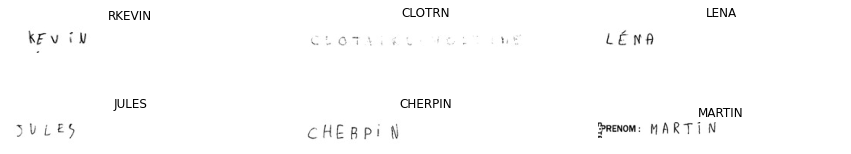

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/input/written_name_test_v2.csv')

plt.figure(figsize=(15, 10))
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_dir = '/content/drive/MyDrive/input/test/'+test.loc[i, 'FILENAME']
    image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    
    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)

# 라벨 벡터화 및 코사인유사도 측정 

## 라벨 벡터화

In [ ]:
train_copy = train.copy()

In [ ]:
def bin(name):

    chars = []

    for i in alphabets:
        count = 0
        for j in name:
            if i == j:
                count +=1
        chars.append(count)

    return chars

train_copy['bin'] = train_copy['IDENTITY'].apply(lambda x: bin(x)) 

In [ ]:
train_copy

,FILENAME,IDENTITY,bin
0,TRAIN_00001.jpg,BALTHAZAR,"[3, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, ..."
1,TRAIN_00002.jpg,SIMON,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, ..."
2,TRAIN_00003.jpg,BENES,"[0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
3,TRAIN_00004.jpg,LA LOVE,"[1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, ..."
4,TRAIN_00005.jpg,DAPHNE,"[1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, ..."
...,...,...,...
32929,TRAIN_32997.jpg,LEANE,"[1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, ..."
32930,TRAIN_32998.jpg,DEBONNE,"[0, 1, 0, 1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, ..."
32931,TRAIN_32999.jpg,PAUL,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
32932,TRAIN_33000.jpg,LOPA,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, ..."


##코사인유사도 측정

In [ ]:
def cos_sim(A, B):
    return dot(A, B)/(norm(A)*norm(B))

In [ ]:
def get_recommendations(text):

    text = bin(text)

    cosine_sim = []
    for i in range(len(train_copy)):
        cosine_sim.append(cos_sim(text, train_copy['bin'][i]))

    sim_scores = list(enumerate(cosine_sim))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[:6]

    text_indices = [j[0] for j in sim_scores]

    plt.figure(figsize=(15, 10))

    for k in range(6):
        ax = plt.subplot(2, 3, k+1)
        
        img_dir = '/content/drive/MyDrive/input/train/'+train.loc[text_indices[k], 'FILENAME']
        image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
        
        plt.imshow(image, cmap='gray')
        plt.title(train.loc[text_indices[k], 'IDENTITY'], fontsize=12)
        plt.axis('off')

    return plt.subplots_adjust(wspace=0.2, hspace=-0.8)

# 결과 출력 

SERRADS


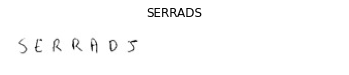

In [ ]:
idx = 125
img_dir = '/content/drive/MyDrive/input/test/'+test.loc[idx, 'FILENAME']
image = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
plt.imshow(image, cmap='gray')

image = preprocess(image)
image = image/255.
pred = model.predict(image.reshape(1, 256, 64, 1))
decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
text = num_to_label(decoded[0])
plt.title(text, fontsize=12)
plt.axis('off')

print(test.loc[idx, 'IDENTITY'])   
plt.subplots_adjust(wspace=0.2, hspace=-0.8)

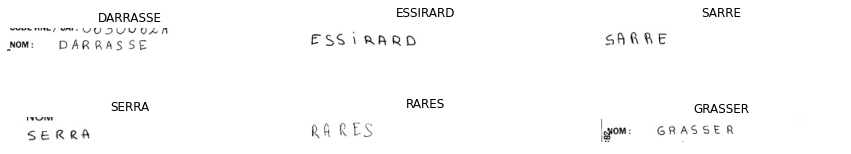

In [ ]:
get_recommendations(text)